In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.distributions as dist
import pyro
import pyro.distributions as pyro_dist
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean, AutoNormal
from pyro.infer import SVI, Trace_ELBO

import bayesreg_pyro as br

In [3]:
data = pd.read_csv("bodyfat.csv").drop("Density", axis=1)
data = data - data.mean()
data.head(3)

,Bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,-6.850794,-21.884921,-24.674405,-2.39881,-1.792063,-7.724206,-7.355952,-5.404762,-0.405952,-1.290476,-1.202381,-0.273413,-1.263889,-1.129762
1,-13.050794,-22.884921,-5.674405,2.10119,0.507937,-7.224206,-9.555952,-1.204762,-0.705952,-1.290476,0.297619,-1.773413,0.236111,-0.029762
2,6.149206,-22.884921,-24.924405,-3.89881,-3.992063,-5.024206,-4.655952,-0.704762,0.194048,0.309524,0.897619,-3.473413,-3.463889,-1.629762


In [4]:
# sns.pairplot(data)
# plt.show()

In [5]:
# prepare data
y_data = torch.Tensor(data["Bodyfat"].values)
x_data = torch.Tensor(data.drop("Bodyfat", axis=1).values)
in_features = x_data.shape[1]

In [11]:
model = br.BayesianRegression(in_features, 1)
guide = AutoDiagonalNormal(model) # Stochastic Mean field
adam = pyro.optim.Adam({"lr": 0.009})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [12]:
torch.manual_seed(12)
pyro.clear_param_store()
tic=time.time()
elbos = model.run_vi(x_data, y_data, svi, num_iterations=5000)
toc=time.time()
print(f"SVI time: {toc-tic} sec")
guide.requires_grad_(False)
samples, iw = br.sample_and_calculate_log_impweight(x_data, y_data, model, guide, num_post_samples=int(1e3))

SVI time: 9.941773176193237 sec


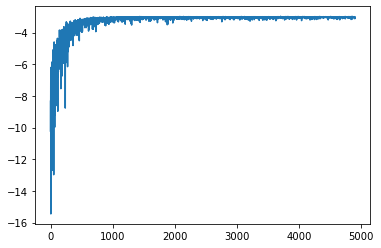

In [13]:
plt.plot(elbos[100:])
plt.show()

In [14]:
posterior_loc = pyro.param("AutoDiagonalNormal.loc").numpy().copy()
posterior_scale = pyro.param("AutoDiagonalNormal.scale").numpy().copy()

# swap the sigma and the bias
# posterior_loc[0], posterior_loc[-1] = posterior_loc[-1], posterior_loc[0]
# posterior_scale[0], posterior_scale[-1] = posterior_scale[-1], posterior_scale[0]

In [15]:
# VI results -- calculated from posterior samples
pd.DataFrame({
    "loc": posterior_loc,
    "scale": posterior_scale,
}, index=["log-sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]).pipe(lambda df: np.round(df, 4))


,loc,scale
log-sigma,1.4607,0.0520
Age,0.0563,0.0273
Weight,-0.0950,0.0140
Height,-0.0735,0.0757
Neck,-0.4899,0.1137
Chest,-0.0243,0.0344
Abdomen,0.9509,0.0296
Hip,-0.2135,0.0434
Thigh,0.2387,0.0536
Knee,0.0005,0.1163


In [16]:
torch.manual_seed(21)
tic = time.time()
hmc_samples = br.run_hmc(x_data, y_data, model)
toc=time.time()
print(f"HMC time: {toc-tic} sec")

Sample: 100%|██████████| 1200/1200 [01:22, 14.55it/s, step size=1.30e-01, acc. prob=0.914]

HMC time: 82.46684312820435 sec


In [15]:
# HMC results
pd.DataFrame({
    "loc": np.append(
        hmc_samples["sigma"].mean(), 
        np.append(hmc_samples["linear.weight"].mean(axis=0), hmc_samples["linear.bias"].mean())
    ), 
    "scale": np.append(
        hmc_samples["sigma"].std(), 
        np.append(hmc_samples["linear.weight"].std(axis=0), hmc_samples["linear.bias"].std() )
    ),
}, index=["sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]).pipe(lambda df: np.round(df, 2))

,loc,scale
sigma,4.32,0.20
Age,0.05,0.03
Weight,-0.10,0.05
Height,-0.07,0.10
Neck,-0.47,0.22
Chest,-0.02,0.10
Abdomen,0.96,0.08
Hip,-0.20,0.14
Thigh,0.24,0.14
Knee,0.01,0.23


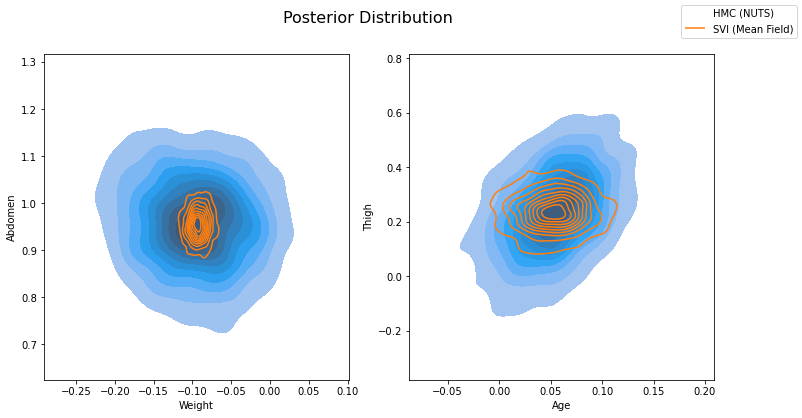

In [16]:
# compare HMC vs VI
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Posterior Distribution", fontsize=16)

sns.kdeplot(x=hmc_samples["linear.weight"][:, 1], y=hmc_samples["linear.weight"][:, 5], ax=axs[0], shade=True, label="HMC (NUTS)")
sns.kdeplot(x=samples[:, 2], y=samples[:, 6], ax=axs[0], label="SVI (Mean Field)")
axs[0].set(xlabel="Weight", ylabel="Abdomen", )

sns.kdeplot(x=hmc_samples["linear.weight"][:, 0], y=hmc_samples["linear.weight"][:,7], ax=axs[1], shade=True, label="HMC (NUTS)")
sns.kdeplot(x=samples[:, 1], y=samples[:, 8], ax=axs[1], label="SVI (Mean Field)")
axs[1].set(xlabel="Age", ylabel="Thigh", )


handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [20]:
# Run non mean-field
torch.manual_seed(12)
pyro.clear_param_store()

guide_mvt = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
svi_mvt = SVI(model, guide_mvt, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())

tic = time.time()
elbos_mvt = model.run_vi(x_data, y_data, svi_mvt, num_iterations=2000)
toc=time.time()
guide_mvt.requires_grad_(False)
samples_mvt, iw_mvt = br.sample_and_calculate_log_impweight(x_data, y_data, model, guide_mvt, num_post_samples=int(1e3))
print(f"Non-MFVI time: {toc-tic} sec")

Non-MFVI time: 23.36562204360962 sec


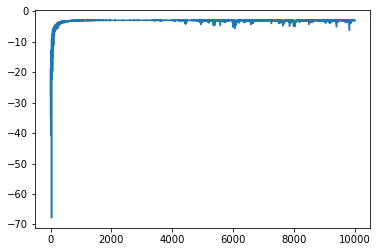

In [21]:
plt.plot(elbos_mvt[10:])
plt.show()

In [22]:
# non-mean field VI results
# use samples for loc and scale this time (alternatively, use pyro.param("AutoMultivariateNormal")...)
np.round(pd.DataFrame({
    "loc": samples_mvt.mean(axis=0),
    "scale": samples_mvt.std(axis=0),
}, index=["sigma"] + list(data.drop("Bodyfat", axis=1).columns) + ["Intercept"]), 2)

,loc,scale
sigma,1.49,0.05
Age,0.07,0.04
Weight,-0.09,0.05
Height,-0.06,0.10
Neck,-0.49,0.23
Chest,-0.01,0.12
Abdomen,0.96,0.11
Hip,-0.21,0.16
Thigh,0.23,0.17
Knee,0.01,0.27


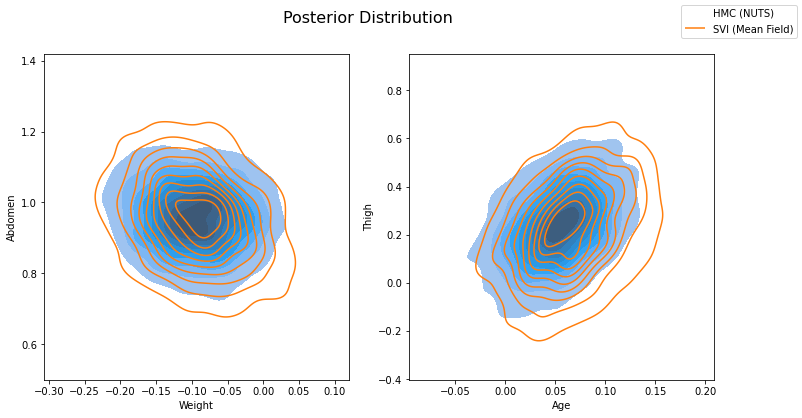

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Posterior Distribution", fontsize=16)

sns.kdeplot(x=hmc_samples["linear.weight"][:,1], y=hmc_samples["linear.weight"][:,5], ax=axs[0], fill=True, label="HMC (NUTS)")
sns.kdeplot(x=samples_mvt[:, 2], y=samples_mvt[:, 6], ax=axs[0], label="SVI (Mean Field)")
axs[0].set(xlabel="Weight", ylabel="Abdomen", )

sns.kdeplot(x=hmc_samples["linear.weight"][:, 0], y=hmc_samples["linear.weight"][:,7], ax=axs[1], fill=True, label="HMC (NUTS)")
sns.kdeplot(x=samples_mvt[:, 1], y=samples_mvt[:, 8], ax=axs[1], label="SVI (Mean Field)")
axs[1].set(xlabel="Age", ylabel="Thigh", )


handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

In [24]:
## seems like the sigmas are mostly off
sigma_MF, sigma_MVT, sigma_HMC = np.exp(samples[:, 0]), np.exp(samples_mvt[:, 0]), hmc_samples["sigma"].reshape(-1, )

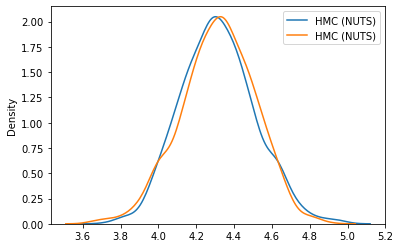

In [32]:
sns.kdeplot(x=sigma_HMC, label="HMC (NUTS)")
sns.kdeplot(x=2*sigma_HMC.mean()-sigma_HMC, label="HMC (NUTS)")
# sns.kdeplot(x=sigma_MF, label="MFVI")
# sns.kdeplot(x=sigma_MVT, label="Non-MF VI")
plt.legend()
plt.show()


In [27]:
from scipy import stats

In [29]:
rvs1 = stats.norm.rvs(size=200, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=200, loc=0., scale=1)

stats.ks_2samp(rvs1, rvs2)

KstestResult(statistic=0.06, pvalue=0.8655265369450457)

In [33]:
stats.ks_2samp(sigma_HMC, 2*sigma_HMC.mean()-sigma_HMC)

KstestResult(statistic=0.037, pvalue=0.5005673707894058)